In [ ]:
%matplotlib inline
import numpy as np
import scipy as sp
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import patsy
import sklearn
from sklearn import neighbors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.feature_selection import RFE
import time
import os
import csv
import urllib.request
import json
import gzip
from pandas import read_json
from pandas.io.json import json_normalize
import io
import dask.array as da

plt.style.use('seaborn')

In [ ]:
#Import Full 2018 Dataset
url = 'https://raw.githubusercontent.com/shinmantis/CSPB-4502/master/data/ks-projects-201801%202.csv'
response = urllib.request.urlopen(url)
df = pd.read_csv(response)
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [ ]:
#There are no duplicate projects
len(df[df.duplicated(subset='ID')])

0

In [ ]:
# Check for null values
# The only category with null values was "name", which is dropped below
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                378661 non-null  int64  
 1   name              378657 non-null  object 
 2   category          378661 non-null  object 
 3   main_category     378661 non-null  object 
 4   currency          378661 non-null  object 
 5   deadline          378661 non-null  object 
 6   goal              378661 non-null  float64
 7   launched          378661 non-null  object 
 8   pledged           378661 non-null  float64
 9   state             378661 non-null  object 
 10  backers           378661 non-null  int64  
 11  country           378661 non-null  object 
 12  usd pledged       374864 non-null  float64
 13  usd_pledged_real  378661 non-null  float64
 14  usd_goal_real     378661 non-null  float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


In [ ]:
# Drop 'ID' and 'name' attributes since they are unique identifiers and will not add to analysis
# Drop 'pledged','usd pledged', and 'goal' since these are duplicated in the 'usd_pledged_real' and 'usd_goal_real' attributes
df.drop(['ID','pledged', 'usd pledged', 'goal'], axis=1, inplace=True)
df.head()

,name,category,main_category,currency,deadline,launched,state,backers,country,usd_pledged_real,usd_goal_real
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,2015-08-11 12:12:28,failed,0,GB,0.0,1533.95
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,2017-09-02 04:43:57,failed,15,US,2421.0,30000.00
2,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,2013-01-12 00:20:50,failed,3,US,220.0,45000.00
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,2012-03-17 03:24:11,failed,1,US,1.0,5000.00
4,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,2015-07-04 08:35:03,canceled,14,US,1283.0,19500.00


In [ ]:
# Examining the dependent variable attributes. Since we are focused on Failure vs. Success, all other outcomes are dropped. 

df['state'].value_counts()

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

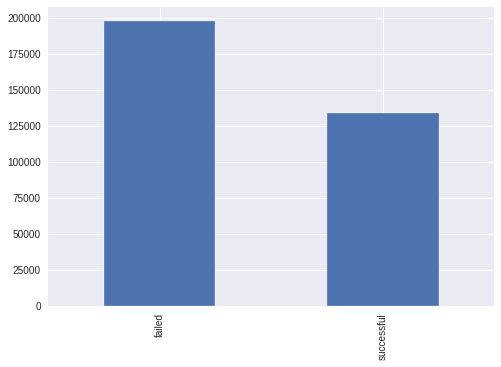

In [ ]:
# Drop projects that aren't success or failure, and check distribution
df = df[df['state'].isin(['successful', 'failed'])]
df['state'].value_counts().plot.bar();

In [ ]:
df.describe()

,backers,usd_pledged_real,usd_goal_real
count,331675.000000,3.316750e+05,3.316750e+05
mean,116.381581,9.943461e+03,4.151000e+04
std,965.427268,9.673293e+04,1.108930e+06
min,0.000000,0.000000e+00,1.000000e-02
25%,2.000000,5.000000e+01,2.000000e+03
50%,15.000000,7.880000e+02,5.000000e+03
75%,63.000000,4.608000e+03,1.500000e+04
max,219382.000000,2.033899e+07,1.663614e+08


In [ ]:
# category = sns.countplot(x='main_category', hue='state',data=df)
# category.set_xticklabels(category.get_xticklabels(), rotation=45, horizontalalignment='right')
# plt.show()

In [ ]:
#add some timeframe specific attributes 
df['launched'] = pd.to_datetime(df['launched'], format="")
df['deadline'] = pd.to_datetime(df['deadline'])

df['year_launched'] = df['launched'].dt.year
df['month_launched'] = df['launched'].dt.month

df['duration_days'] = (df['deadline'] - df['launched']).dt.days

In [ ]:
#Examine successful categories 
film_video = df[(df['main_category'] == 'Film & Video') & (df['state'] == 'successful')]
film_video.head()

,name,category,main_category,currency,deadline,launched,state,backers,country,usd_pledged_real,usd_goal_real,year_launched,month_launched,duration_days
27,Permaculture Skills,Webseries,Film & Video,CAD,2014-12-14,2014-11-14 18:02:00,successful,571,CA,42174.03,15313.04,2014,11,29
29,My Moon - Animated Short Film,Animation,Film & Video,USD,2017-05-03,2017-04-03 17:11:33,successful,840,US,57577.31,50000.00,2017,4,29
37,Zen in America: a film on Zen Buddhism in Nort...,Documentary,Film & Video,USD,2013-10-21,2013-09-21 23:00:54,successful,213,US,15663.00,10000.00,2013,9,29
47,Star and the Snowman,Narrative Film,Film & Video,USD,2013-02-23,2013-01-24 06:04:05,successful,154,US,9401.00,8000.00,2013,1,29
50,I'LL SEE YOU IN MY DREAMS - narrative feature ...,Narrative Film,Film & Video,USD,2014-02-05,2014-01-11 00:57:14,successful,632,US,61365.16,60000.00,2014,1,24


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


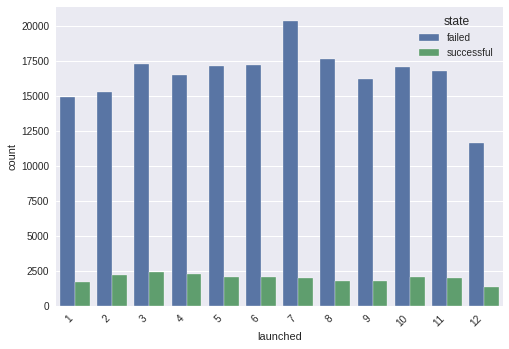

In [ ]:
#Film and Video Success and failures by month and their counts
film_video_SF = df[(df['main_category'] == 'Film & Video') & (df['state'] == 'successful') | (df['state'] == 'failed' )]
film_video_SF.launched = pd.to_datetime(film_video_SF['launched'], format="")

category = sns.countplot(x=film_video_SF.launched.dt.month, hue=film_video_SF.state, data=film_video)
category.set_xticklabels(category.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


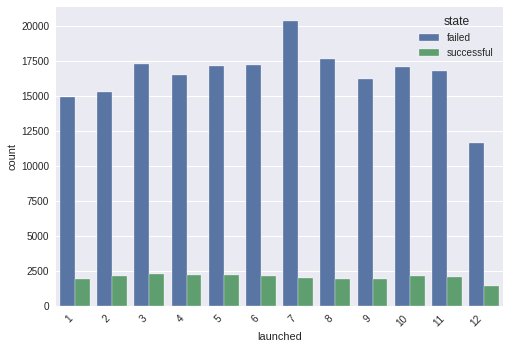

In [ ]:
#Music and Video Success and failures by month and their counts
film_video_SF = df[(df['main_category'] == 'Music') & (df['state'] == 'successful') | (df['state'] == 'failed' )]
film_video_SF.launched = pd.to_datetime(film_video_SF['launched'], format="")

category = sns.countplot(x=film_video_SF.launched.dt.month, hue=film_video_SF.state, data=film_video)
category.set_xticklabels(category.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

Text(0.5, 0, '')

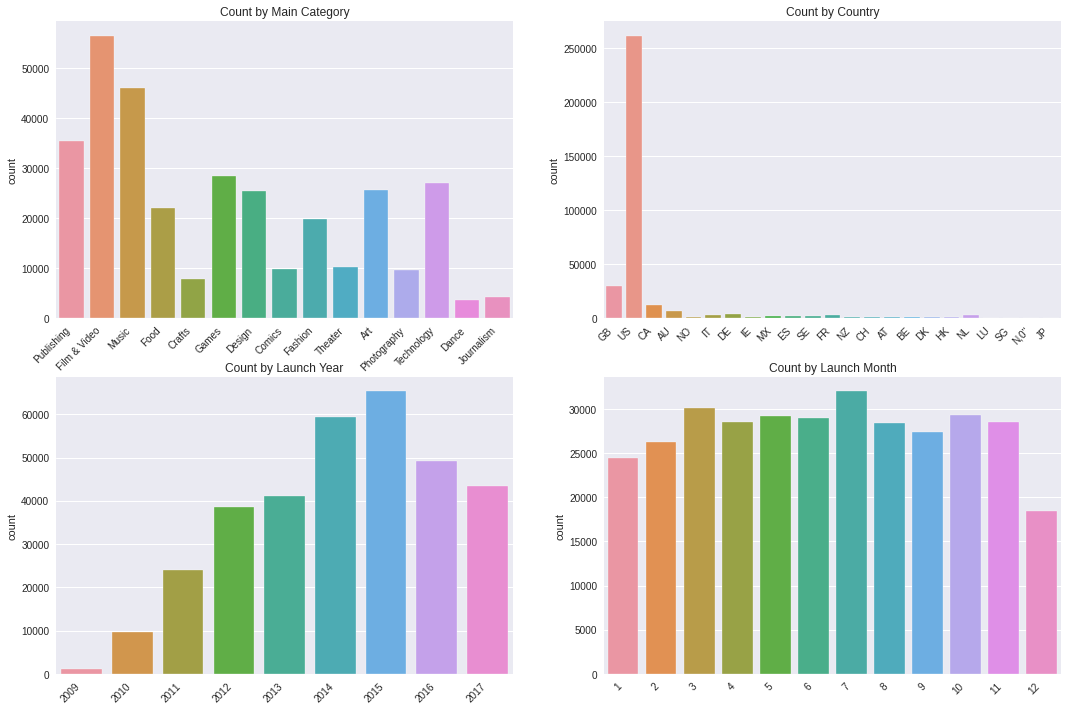

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18,12))

#Number of projects by Main Category
sns.countplot(x='main_category',data=df, ax = ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, horizontalalignment='right');
ax1.set_title('Count by Main Category')
ax1.set_xlabel('')

#Number of projects by Country
sns.countplot(x='country',data=df, ax = ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, horizontalalignment='right')
ax2.set_title('Count by Country')
ax2.set_xlabel('')

#Number of projects by Year Launched
sns.countplot(x='year_launched',data=df, ax = ax3)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, horizontalalignment='right');
ax3.set_title('Count by Launch Year')
ax3.set_xlabel('')

#Number of projects by Month Launched
sns.countplot(x='month_launched',data=df, ax = ax4)
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45, horizontalalignment='right');
ax4.set_title('Count by Launch Month')
ax4.set_xlabel('')

Text(0.5, 0, '')

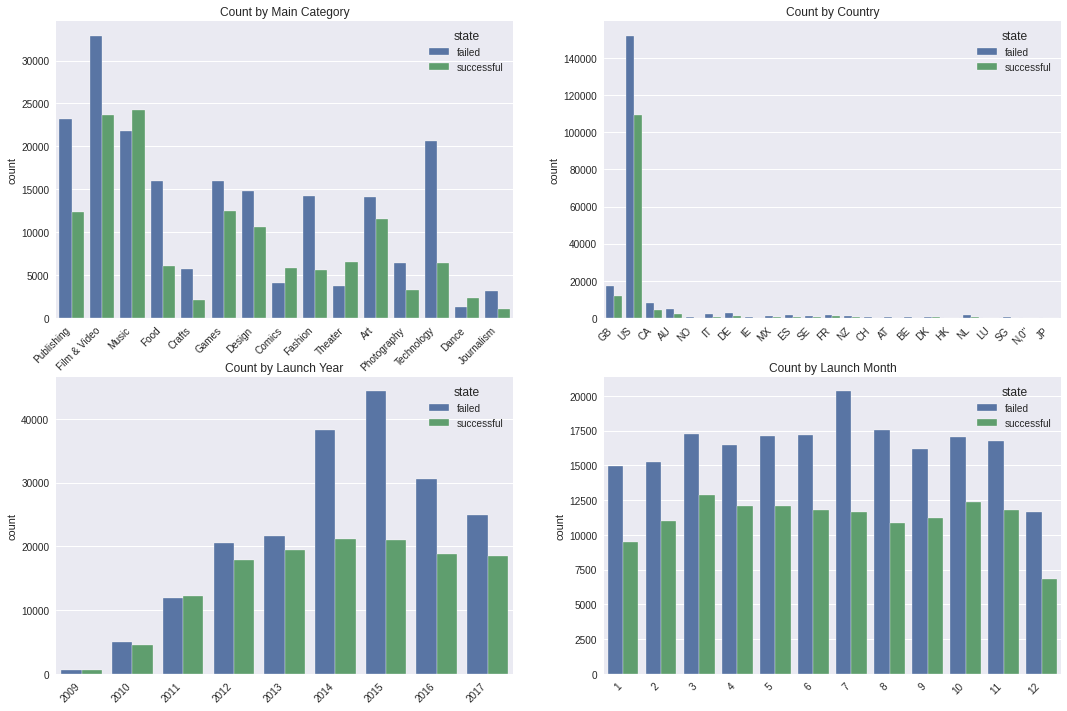

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18,12))

#Number of projects by Main Category, separated by failure and success
sns.countplot(x='main_category',data=df, ax = ax1, hue='state')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, horizontalalignment='right');
ax1.set_title('Count by Main Category')
ax1.set_xlabel('')

#Number of projects by Country, separated by failure and success
sns.countplot(x='country',data=df, ax = ax2, hue='state')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, horizontalalignment='right')
ax2.set_title('Count by Country')
ax2.set_xlabel('')

#Number of projects by Launch Year, separated by failure and success
sns.countplot(x='year_launched',data=df, ax = ax3, hue='state')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, horizontalalignment='right');
ax3.set_title('Count by Launch Year')
ax3.set_xlabel('')

#Number of projects by Launch Month, separated by failure and success
sns.countplot(x='month_launched',data=df, ax = ax4, hue='state')
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45, horizontalalignment='right');
ax4.set_title('Count by Launch Month')
ax4.set_xlabel('')

Text(0.5, 0, '')

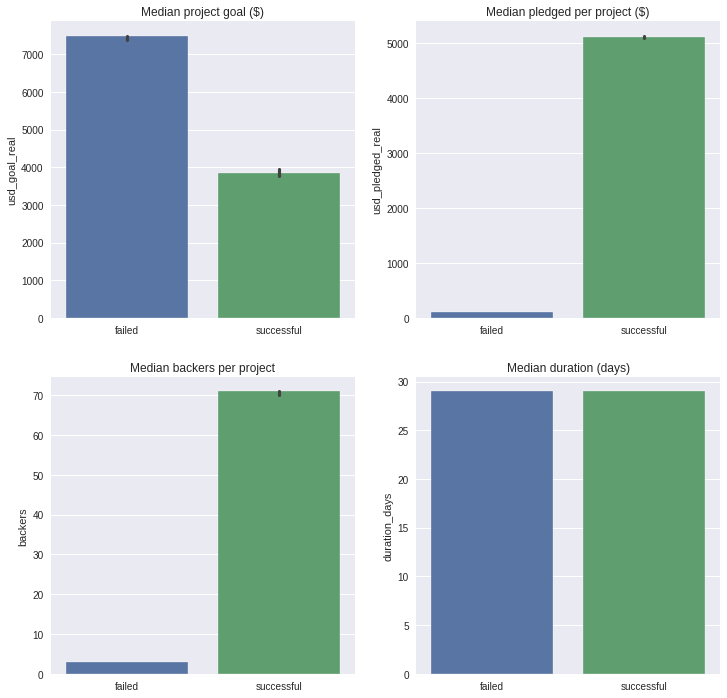

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,12))

#Median Goal by State
sns.barplot(data=df, x='state',y='usd_goal_real',ax = ax1, estimator=np.median)
ax1.set_title('Median project goal ($)')
ax1.set_xlabel('')

#Median Pledged by State
sns.barplot(data=df, x='state',y='usd_pledged_real',ax = ax2, estimator=np.median)
ax2.set_title('Median pledged per project ($)')
ax2.set_xlabel('')

#Median Number of Backers by State
sns.barplot(data=df, x='state',y='backers',ax = ax3, estimator=np.median)
ax3.set_title('Median backers per project')
ax3.set_xlabel('')

#Median Duration by State
sns.barplot(data=df, x='state',y='duration_days',ax = ax4, estimator=np.median)
ax4.set_title('Median duration (days)')
ax4.set_xlabel('')

''

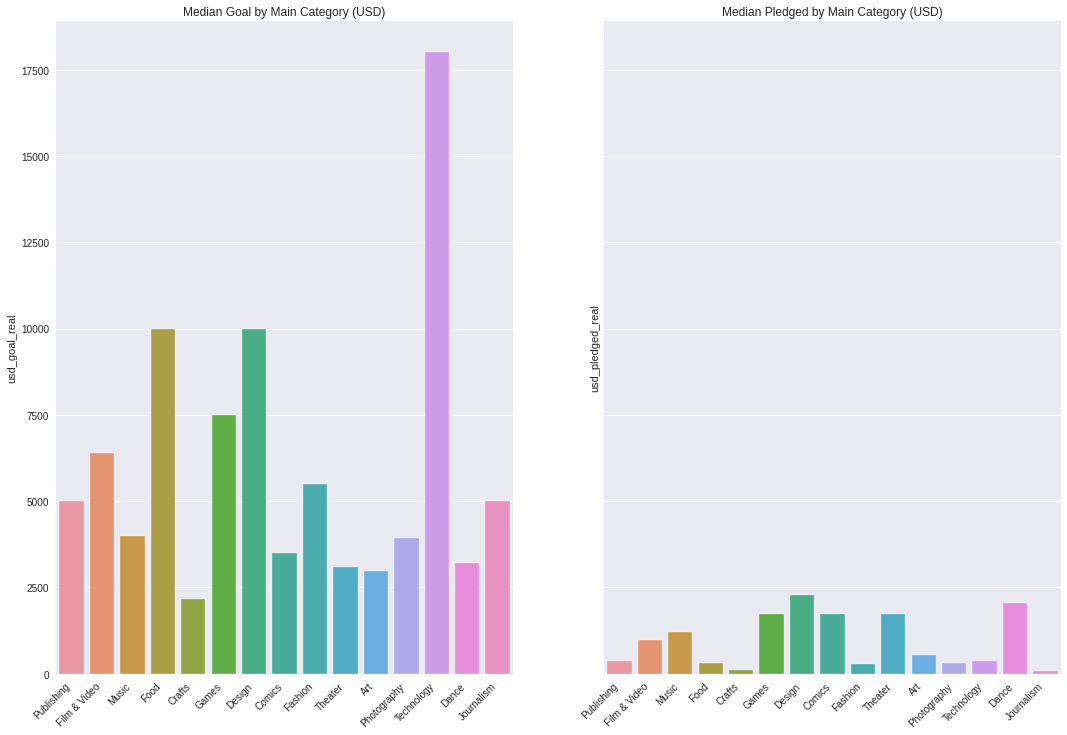

In [ ]:
# Median/goal vs. Median/pledged by category for all projects --

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(18,12))

sns.barplot(data=df, x='main_category',y='usd_goal_real', estimator=np.median,ax=ax1, ci=None)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, horizontalalignment='right')
ax1.set_title('Median Goal by Main Category (USD)')
ax1.set_xlabel('')

sns.barplot(data=df, x='main_category',y='usd_pledged_real', estimator=np.median, ax=ax2, ci=None)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, horizontalalignment='right')
ax2.set_title('Median Pledged by Main Category (USD)')
ax2.set_xlabel('')
;

In [ ]:
# Create separate dataframes for successful projects and failed projects to compare interesing features

failed = df.loc[df.state=='failed']
successful = df.loc[df.state=='successful']


''

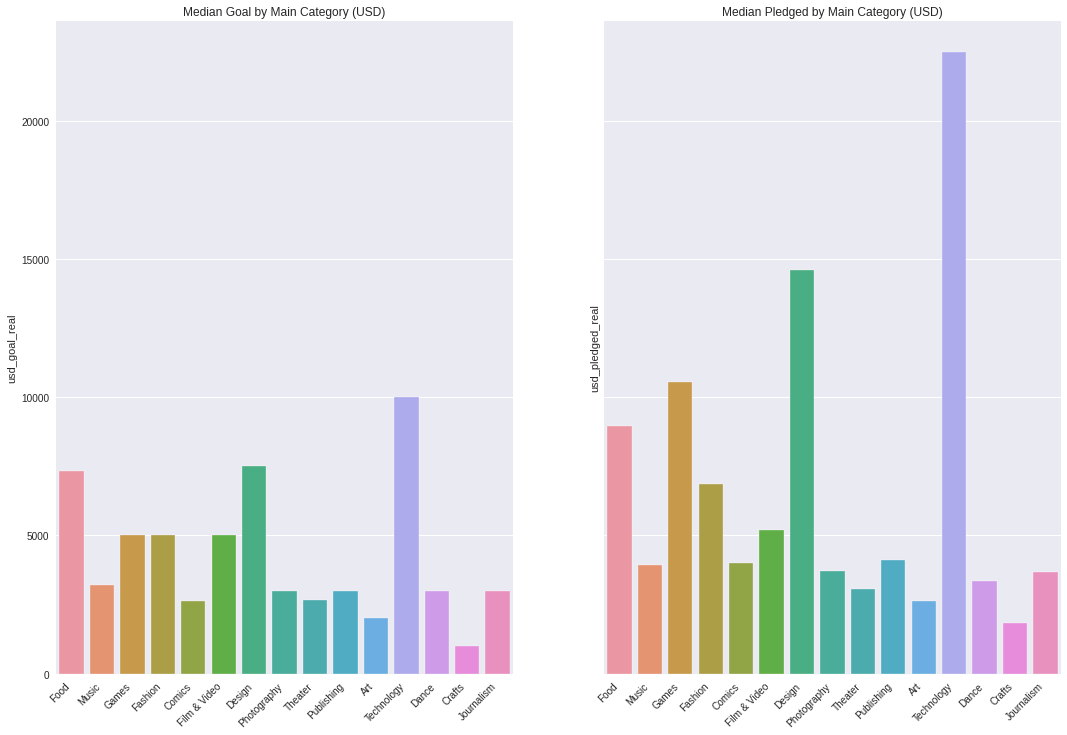

In [ ]:
# Median/goal vs. Median/pledged by category for successful projects --

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(18,12))

sns.barplot(data=successful, x='main_category',y='usd_goal_real', estimator=np.median,ax=ax1, ci=None)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, horizontalalignment='right')
ax1.set_title('Median Goal by Main Category (USD)')
ax1.set_xlabel('')

sns.barplot(data=successful, x='main_category',y='usd_pledged_real', estimator=np.median, ax=ax2, ci=None)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, horizontalalignment='right')
ax2.set_title('Median Pledged by Main Category (USD)')
ax2.set_xlabel('')
;

''

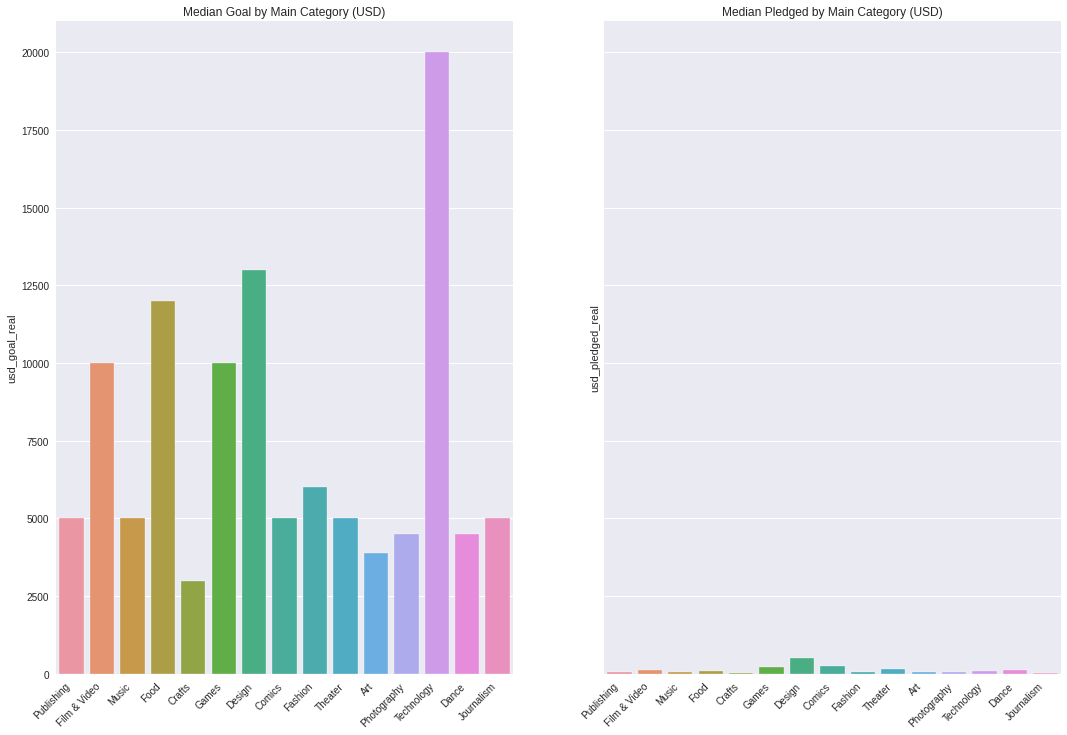

In [ ]:
# Median/goal vs. Median/pledged by category for failed projects --

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(18,12))

sns.barplot(data=failed, x='main_category',y='usd_goal_real', estimator=np.median,ax=ax1, ci=None)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, horizontalalignment='right')
ax1.set_title('Median Goal by Main Category (USD)')
ax1.set_xlabel('')

sns.barplot(data=failed, x='main_category',y='usd_pledged_real', estimator=np.median, ax=ax2, ci=None)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, horizontalalignment='right')
ax2.set_title('Median Pledged by Main Category (USD)')
ax2.set_xlabel('')
;

In [ ]:
groupby_main_category = successful.groupby(['main_category']).median()
groupby_main_category.drop(columns=['month_launched', 'duration_days', 'year_launched'], inplace=True)
groupby_main_category['median_pledge_per_backer'] = groupby_main_category['usd_pledged_real'] / groupby_main_category['backers']
groupby_main_category

,backers,usd_pledged_real,usd_goal_real,mean_pledge_per_backer
main_category,,,,
Art,43.0,2630.850,2000.00,61.182558
Comics,101.0,4000.000,2619.71,39.603960
Crafts,37.0,1825.000,1000.00,49.324324
Dance,45.0,3364.000,3000.00,74.755556
Design,168.0,14619.300,7500.00,87.019643
Fashion,77.0,6864.090,5000.00,89.144026
Film & Video,57.0,5210.000,5000.00,91.403509
Food,96.0,8951.820,7343.91,93.248125
Games,220.0,10571.540,5000.00,48.052455


In [ ]:
groupby_main_category_failed = failed.groupby(['main_category']).median()
groupby_main_category_failed.drop(columns=['month_launched', 'duration_days', 'year_launched'], inplace=True)
groupby_main_category_failed['median_pledge_per_backer'] = groupby_main_category_failed['usd_pledged_real'] / groupby_main_category_failed['backers']
groupby_main_category_failed

,backers,usd_pledged_real,usd_goal_real,mean_pledge_per_backer
main_category,,,,
Art,3,67.000,3879.22,22.333333
Comics,8,247.000,5000.00,30.875000
Crafts,2,37.000,3000.00,18.500000
Dance,4,105.000,4500.00,26.250000
Design,10,490.360,13000.00,49.036000
Fashion,2,70.000,6000.00,35.000000
Film & Video,3,105.000,10000.00,35.000000
Food,3,81.000,12000.00,27.000000
Games,7,222.000,10000.00,31.714286


In [ ]:
percent_successful = pd.DataFrame()
percent_successful["Total Projects"] = df.groupby(['main_category']).launched.count()
percent_successful['Successful'] = successful.groupby(['main_category']).launched.count()
percent_successful['% Success'] = (percent_successful['Successful'] / percent_successful["Total Projects"]) * 100
percent_successful.reset_index()

,main_category,Total Projects,Successful,% Success
0,Art,25641,11510,44.889045
1,Comics,9878,5842,59.141527
2,Crafts,7818,2115,27.052955
3,Dance,3573,2338,65.435209
4,Design,25364,10550,41.594386
5,Fashion,19775,5593,28.283186
6,Film & Video,56527,23623,41.790649
7,Food,22054,6085,27.591367
8,Games,28521,12518,43.890467
9,Journalism,4149,1012,24.391420


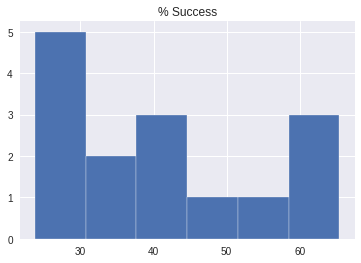

In [ ]:
percent_successful.hist(column='% Success', bins = 6);

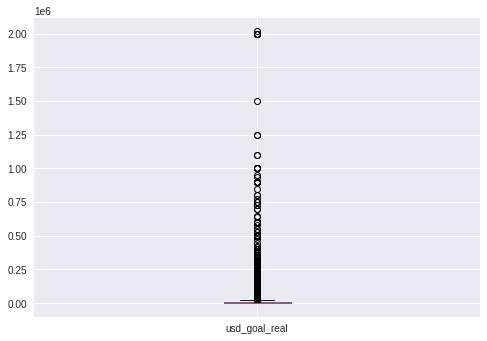

In [ ]:
# Analysis of Goal amounts 

successful.boxplot(column=['usd_goal_real']);

In [ ]:
successful['usd_goal_real'].describe().apply(lambda x: format(x, 'f'))

count     133956.000000
mean        9532.853357
std        27961.442312
min            0.010000
25%         1301.915000
50%         3837.740000
75%        10000.000000
max      2015608.880000
Name: usd_goal_real, dtype: object

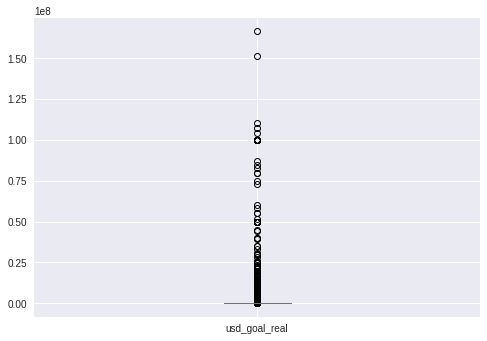

In [ ]:
failed.boxplot(column=['usd_goal_real']);

In [ ]:
failed['usd_goal_real'].describe().apply(lambda x: format(x, 'f'))

count       197719.000000
mean         63174.742222
std        1435682.631735
min              0.150000
25%           2500.000000
50%           7500.000000
75%          20000.000000
max      166361390.710000
Name: usd_goal_real, dtype: object

In [ ]:
q1 = 1301.92
q3 = 10000
iqr = q3 - q1
max_whisker = q3 + (iqr * 1.5)
min_whisker = q1 - (iqr * 1.5)
print("Outliers are < {} and > {}".format(min_whisker, max_whisker))

Outliers are < -11745.199999999999 and > 23047.12


In [ ]:
out_count = (successful['usd_goal_real']> max_whisker).sum()
print("There are {} outliers".format(out_count))
perc = out_count / df['usd_goal_real'].count() * 100
print("This is", perc ,"percent of the dataset and thus these are not considered to be outliers" )

There are 12277 outliers
This is 3.70151503731062 percent of the dataset and thus these are not considered to be outliers


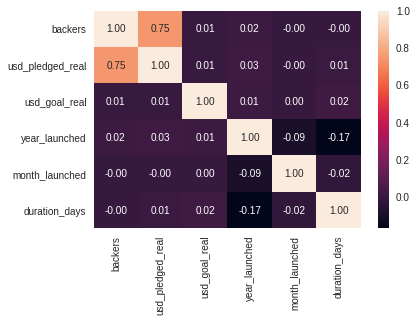

In [ ]:
# Check correlation of attributes 

sns.heatmap(df.corr(), annot=True, fmt=".2f")
plt.show()

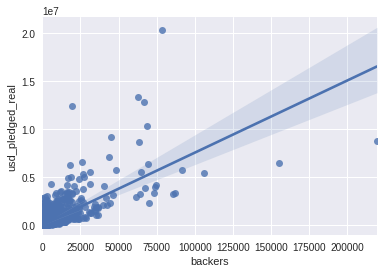

In [ ]:
# Strong positive correlation between backers and amount pledged

sns.regplot(x='backers',y='usd_pledged_real', data=successful);

In [ ]:
#brief snapshot of our preprocesed data
df.head()

,name,category,main_category,currency,deadline,launched,state,backers,country,usd_pledged_real,usd_goal_real,year_launched,month_launched,duration_days
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,2015-08-11 12:12:28,failed,0,GB,0.0,1533.95,2015,8,58
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,2017-09-02 04:43:57,failed,15,US,2421.0,30000.00,2017,9,59
2,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,2013-01-12 00:20:50,failed,3,US,220.0,45000.00,2013,1,44
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,2012-03-17 03:24:11,failed,1,US,1.0,5000.00,2012,3,29
5,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,2016-02-26 13:38:27,successful,224,US,52375.0,50000.00,2016,2,34


In [ ]:
# Create dataframe with balanced data for model training 
df_pass = df[df['state'] == 'successful'].sample(100000, random_state = 113)
df_fail = df[df['state'] == 'failed'].sample(100000, random_state = 113)
df = pd.concat([df_pass, df_fail], axis=0).reset_index(drop=True)
df= shuffle(df)

#scale numerical categories 
max = df['usd_goal_real'].max()
min = df['usd_goal_real'].min()
df['goal'] = (df['usd_goal_real'] - min)/(max - min)


In [ ]:
#Change state to binary variables
df['state'] = df['state'].replace({'failed': 0, 'successful': 1})

# Transforming duration days into categorical variables (discretization)
df['duration_days'] = np.where(df['duration_days'].between(0,15, inclusive = True), 0, df['duration_days'])
df['duration_days'] = np.where(df['duration_days'].between(16,30, inclusive = True), 1, df['duration_days'])
df['duration_days'] = np.where(df['duration_days'].between(31,45, inclusive = True), 2, df['duration_days'])
df['duration_days'] = np.where(df['duration_days'].between(46,60, inclusive = True), 3, df['duration_days'])
df['duration_days'] = np.where(df['duration_days'].between(61,75, inclusive = True), 4, df['duration_days'])
df['duration_days'] = np.where(df['duration_days'].between(76,91, inclusive = True), 5, df['duration_days'])

#One hot encoding of remaining categorical variables 
df = pd.get_dummies(df, prefix = ['Cat:', 'Month:', 'Duration:'], columns = ['main_category','month_launched', 'duration_days'])

In [ ]:
df_processed = df.copy(deep=True);

In [ ]:
df_processed.drop(['name', 'category', 'currency', 'deadline', 'launched', 'country', 'usd_goal_real', 'year_launched','usd_pledged_real', 'backers'], axis=1, inplace=True)

In [ ]:
df_processed.head()

,state,goal,Cat:_Art,Cat:_Comics,Cat:_Crafts,Cat:_Dance,Cat:_Design,Cat:_Fashion,Cat:_Film & Video,Cat:_Food,Cat:_Games,Cat:_Journalism,Cat:_Music,Cat:_Photography,Cat:_Publishing,Cat:_Technology,Cat:_Theater,Month:_1,Month:_2,Month:_3,Month:_4,Month:_5,Month:_6,Month:_7,Month:_8,Month:_9,Month:_10,Month:_11,Month:_12,Duration:_0,Duration:_1,Duration:_2,Duration:_3,Duration:_4,Duration:_5
155738,0,0.000301,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
69015,1,0.000016,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
134070,0,0.000048,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
146137,0,0.000022,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
144467,0,0.000152,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0


In [ ]:

df_y = df_processed.state
X = df_processed.drop(['state'], axis=1)

In [ ]:
# Logisitic Regression Model using all Data Points

X_train, X_test, y_train, y_test = train_test_split(X,df_y, test_size=0.30, random_state=101, stratify=df_y)

#Instantiate our linear logisitic regression model
lr = sklearn.linear_model.LogisticRegression(max_iter=500)
#get our predicted model data from our model
predicted_model_all_data = lr.fit(X_train, y_train)

#print the score for our model output
print('Score is', predicted_model_all_data.score(X_train,y_train))

Score is 0.6028571428571429


In [ ]:
#RFE Test to check for Feature importance 
predictors = X_train
selector = RFE(lr, n_features_to_select= 1)
selector = selector.fit(predictors, y_train)
order = selector.ranking_
print(order)
column_list = (list(X_train.columns))



[ 1 21 10  7  2 29  8 26  6 25  5 11 14 15  4  3 20 32 24 27 33 34 16 18
 31 28 30 19 13 23 17  9 22 12]


In [ ]:
# List of top 10 attributes
attr_list = []
for i in range(0, len(order)):
  if order[i] < 11:
    attr_list.append(column_list[i])
    print(column_list[i], order[i])

goal 1
Cat:_Comics 10
Cat:_Crafts 7
Cat:_Dance 2
Cat:_Fashion 8
Cat:_Food 6
Cat:_Journalism 5
Cat:_Technology 4
Cat:_Theater 3
Duration:_3 9


In [ ]:
Z = X_train[attr_list].copy();
Z_test = X_test[attr_list].copy();

In [ ]:
# Logisitic Regression Model using top 10 attributes from RFE

#Instantiate our linear logisitic regression model
lr = sklearn.linear_model.LogisticRegression(max_iter=500)
#get our predicted model data from our model
predicted_model_final = lr.fit(Z, y_train)

#print the score for our model output
print('Score is', predicted_model_final.score(Z,y_train))

Score is 0.59175


In [ ]:
#Now use the prediction model to make a prediction based on the test data Z_test
predicted = predicted_model_final.predict(Z_test)

#Generate the accuracy score based on what was predicted to what the actual values were.
acc_score = sklearn.metrics.accuracy_score(y_test, predicted)
precision_score = sklearn.metrics.precision_score(y_test, predicted)
recall_score = sklearn.metrics.recall_score(y_test, predicted)
print("The accuracy score is",acc_score)
print("The precision score is",precision_score)
print("The recall score is",recall_score)

The accuracy score is 0.58895
The precision score is 0.564172859101075
The recall score is 0.782


In [ ]:
print(predicted_model_final.coef_)
print(attr_list)

[[-5.56202457  0.65375728 -0.73648149  1.01362189 -0.69993923 -0.71489324
  -0.85690589 -0.88493908  0.79171725 -0.70765371]]
['goal', 'Cat:_Comics', 'Cat:_Crafts', 'Cat:_Dance', 'Cat:_Fashion', 'Cat:_Food', 'Cat:_Journalism', 'Cat:_Technology', 'Cat:_Theater', 'Duration:_3']


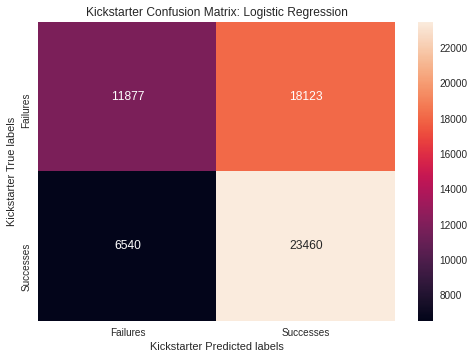

In [ ]:
#Lets take a look at the actual results and make a Confusion Matrix
#A heatmap will make a nice visualization for the results
cm = sklearn.metrics.confusion_matrix(y_test, predicted)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Kickstarter Predicted labels');ax.set_ylabel('Kickstarter True labels'); 
ax.set_title('Kickstarter Confusion Matrix: Logistic Regression'); 
ax.xaxis.set_ticklabels(['Failures', 'Successes']); ax.yaxis.set_ticklabels(['Failures', 'Successes']);

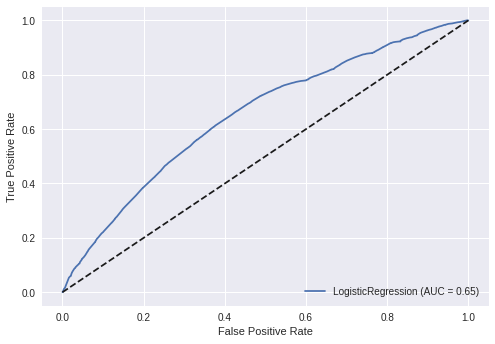

In [ ]:
#ROC curve
from sklearn import  metrics

metrics.plot_roc_curve(predicted_model_final, Z_test, y_test) 
plt.plot([0, 1], [0, 1], 'k--')
plt.show()     